сайт соревнования Semeval-2021 Task 2: [Multilingual and Cross-lingual Word-in-Context Disambiguation](https://competitions.codalab.org/competitions/27054)

In [1]:
!git clone -q  https://github.com/DanilDmitriev1999/ABBYY_HW_NLP

In [2]:
!pip install --upgrade -r /content/ABBYY_HW_NLP/WiC/requirements.txt

     |████████████████████████████████| 7.0MB 4.8MB/s 
     |████████████████████████████████| 12.8MB 203kB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 696kB 46.8MB/s 
     |████████████████████████████████| 2.3MB 49.1MB/s 
     |████████████████████████████████| 1.2MB 40.6MB/s 
     |████████████████████████████████| 22.3MB 98kB/s 
     |████████████████████████████████| 276kB 49.2MB/s 
     |████████████████████████████████| 829kB 38.6MB/s 
     |████████████████████████████████| 112kB 40.3MB/s 
     |████████████████████████████████| 3.3MB 47.7MB/s 
     |████████████████████████████████| 901kB 40.5MB/s 
     |████████████████████████████████| 1.3MB 42.7MB/s 
     |████████████████████████████████| 296kB 52.2MB/s 
     |████████████████████████████████| 143kB 53.4MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44620 sha256=844d2877764e70d6f054cb3badeafaf9aa4d3043c5deaf4238fbc3c0154040eb
 

In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import torch
import random
import numpy as np
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
from torch.utils.data import Dataset, RandomSampler, DataLoader
from torch import nn
from torch.nn import functional as F


from transformers import BertModel, AdamW, get_linear_schedule_with_warmup, AutoModel
from transformers import BertTokenizerFast


In [4]:
from ABBYY_HW_NLP.WiC.DataModule.custom_dataset import *
from ABBYY_HW_NLP.WiC.DataModule.utils import *

In [5]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

### Скачиваем данные с гитхаба соревнования

In [6]:
!mkdir data && git clone https://github.com/SapienzaNLP/mcl-wic.git data && cd data && unzip 'SemEval-2021_MCL-WiC_all-datasets.zip'  && mv 'SemEval-2021_MCL-WiC_test-gold-data.zip' 'MCL-WiC/test' && cd MCL-WiC/test && unzip 'SemEval-2021_MCL-WiC_test-gold-data.zip' && rm *.zip && cd ../.. && rm *.zip && ls


Cloning into 'data'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 188 (delta 41), reused 0 (delta 0), pack-reused 96
Receiving objects: 100% (188/188), 7.59 MiB | 30.60 MiB/s, done.
Resolving deltas: 100% (68/68), done.
Archive:  SemEval-2021_MCL-WiC_all-datasets.zip
   creating: MCL-WiC/
   creating: MCL-WiC/training/
  inflating: MCL-WiC/training/training.en-en.data  
  inflating: MCL-WiC/training/training.en-en.gold  
  inflating: MCL-WiC/README.txt      
   creating: MCL-WiC/test/
   creating: MCL-WiC/test/crosslingual/
  inflating: MCL-WiC/test/crosslingual/test.en-ar.data  
  inflating: MCL-WiC/test/crosslingual/test.en-zh.data  
  inflating: MCL-WiC/test/crosslingual/test.en-ru.data  
  inflating: MCL-WiC/test/crosslingual/test.en-fr.data  
   creating: MCL-WiC/test/multilingual/
  inflating: MCL-WiC/test/multilingual/test.fr-fr.data  
  inflating: MCL-WiC/test/multilingual/

In [7]:
df_train_wic = read_train_data('data/MCL-WiC/training/training.en-en.data', True)
df_dev_wic = read_train_data('data/MCL-WiC/dev/multilingual/dev.en-en.data', True)
df_test_wic = read_train_data('data/MCL-WiC/test/multilingual/test.en-en.data', True)
print(df_train_wic.shape)
print(df_dev_wic.shape)
print(df_test_wic.shape)
print(df_train_wic.head())
print(df_dev_wic.head())
print(df_test_wic.head())

(8000, 10)
(1000, 10)
(1000, 10)
                 id   lemma   pos  ... start2 end2 tag
0  training.en-en.0    play  NOUN  ...     10   14   0
1  training.en-en.1    play  NOUN  ...    112  116   0
2  training.en-en.2  esteem  NOUN  ...    106  112   1
3  training.en-en.3  esteem  NOUN  ...     20   26   1
4  training.en-en.4  holder  NOUN  ...     27   33   1

[5 rows x 10 columns]
            id         lemma   pos  ... start2 end2 tag
0  dev.en-en.0      superior  NOUN  ...     41   50   0
1  dev.en-en.1      superior  NOUN  ...     44   53   1
2  dev.en-en.2  acquaintance  NOUN  ...     41   54   0
3  dev.en-en.3  acquaintance  NOUN  ...     74   86   0
4  dev.en-en.4       baggage  NOUN  ...      6   13   1

[5 rows x 10 columns]
             id   lemma   pos  ... start2 end2 tag
0  test.en-en.0  gently   ADV  ...     59   65   0
1  test.en-en.1  gently   ADV  ...     72   78   0
2  test.en-en.2    next   ADJ  ...     85   89   1
3  test.en-en.3    next   ADJ  ...     84   88   1


### Разбиваем по леммам

In [8]:
global_df = pd.concat([df_train_wic, df_dev_wic], ignore_index=True)
df_train, df_val = lemma_train_test_split(global_df)

df_test = df_test_wic
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)


(7176, 10)
(1824, 10)
(1000, 10)


In [9]:
train_labels = df_train["tag"].tolist()
val_labels = df_val["tag"].tolist()
test_labels = df_test["tag"].tolist()

train_sentences = [(s1, s2) for s1, s2 in zip(df_train["sentence1"], df_train["sentence2"])]
val_sentences = [(s1, s2) for s1, s2 in zip(df_val["sentence1"], df_val["sentence2"])]
test_sentences = [(s1, s2) for s1, s2 in zip(df_test["sentence1"], df_test["sentence2"])]

train_word_ranges = [((int(s1), int(e1)), (int(s2), int(e2))) for s1, e1, s2, e2 in zip(df_train["start1"], df_train["end1"], df_train["start2"], df_train["end2"])]
val_word_ranges = [((int(s1), int(e1)), (int(s2), int(e2))) for s1, e1, s2, e2 in zip(df_val["start1"], df_val["end1"], df_val["start2"], df_val["end2"])]
test_word_ranges = [((int(s1), int(e1)), (int(s2), int(e2))) for s1, e1, s2, e2 in zip(df_test["start1"], df_test["end1"], df_test["start2"], df_test["end2"])]

print(train_sentences[0])
print(train_word_ranges[0])

('We would also like to convey our esteem and congratulations to fraternal Lebanon and its people on the unconditional liberation of its southern part.', 'Father Lini said that, because of that, the United Nations has a very special place in the affections and esteem of the people of Vanuatu.')
((33, 39), (106, 112))


# эксплоративный анализ данных (статистика по корпусу: сколько есть различных слов, как распределены части речи и т.д.)

In [10]:
df_train_wic.head()

,id,lemma,pos,sentence1,sentence2,start1,end1,start2,end2,tag
0,training.en-en.0,play,NOUN,In that context of coordination and integratio...,A musical play on the same subject was also st...,69,73,10,14,0
1,training.en-en.1,play,NOUN,In that context of coordination and integratio...,"In schools, when water is needed, it is girls ...",69,73,112,116,0
2,training.en-en.2,esteem,NOUN,We would also like to convey our esteem and co...,"Father Lini said that, because of that, the Un...",33,39,106,112,1
3,training.en-en.3,esteem,NOUN,We would also like to convey our esteem and co...,This attests to the esteem and trust enjoyed b...,33,39,20,26,1
4,training.en-en.4,holder,NOUN,This growth is the direct result of the increa...,A person may be either the holder of an option...,74,81,27,33,1


In [11]:
df_train_wic.shape

(8000, 10)

## Pos distribution

In [12]:
from collections import Counter
import matplotlib.pyplot as plt

import json
import numpy as np
import pandas as pd
import re

import nltk
from nltk.corpus import stopwords
from functools import reduce

### train

Counter({'NOUN': 4124, 'VERB': 2270, 'ADJ': 1430, 'ADV': 176})


<BarContainer object of 4 artists>

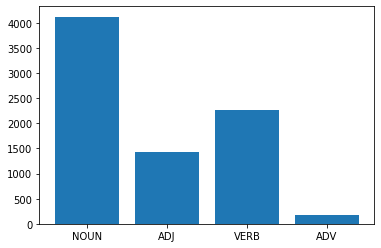

In [13]:
count = Counter()
for i in range(df_train_wic.shape[0]):
    count[df_train_wic.iloc[i]['pos']] += 1

print(count)
plt.bar(count.keys(), count.values())

### val

Counter({'NOUN': 582, 'VERB': 246, 'ADJ': 158, 'ADV': 14})


<BarContainer object of 4 artists>

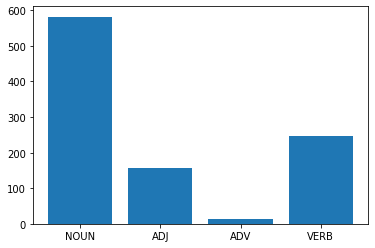

In [15]:
count = Counter()
for i in range(df_dev_wic.shape[0]):
    count[df_dev_wic.iloc[i]['pos']] += 1

print(count)
plt.bar(count.keys(), count.values())

## Label distribution

### train

Counter({'0': 4000, '1': 4000})


<BarContainer object of 2 artists>

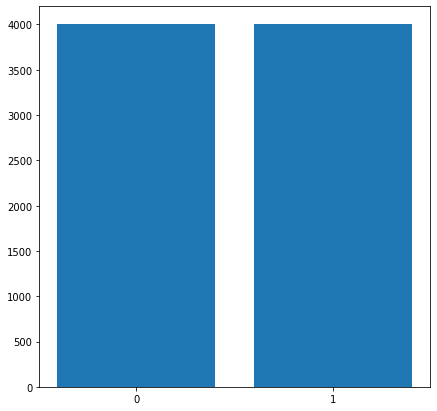

In [18]:
count = Counter()
for i in range(df_train_wic.shape[0]):
    count[str(df_train_wic.iloc[i]['tag'])] += 1

print(count)
plt.figure(figsize=(7, 7))
plt.bar(count.keys(), count.values())    

### val

Counter({'0': 500, '1': 500})


<BarContainer object of 2 artists>

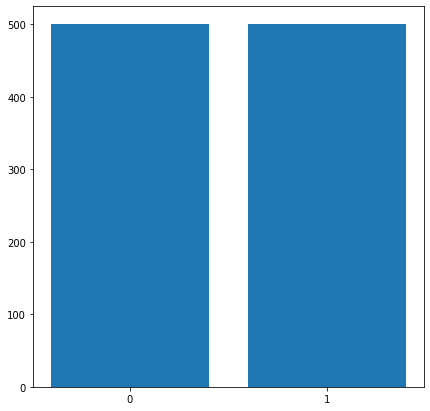

In [17]:
count = Counter()
for i in range(df_dev_wic.shape[0]):
    count[str(df_dev_wic.iloc[i]['tag'])] += 1

print(count)
plt.figure(figsize=(7, 7))
plt.bar(count.keys(), count.values())   

## Len sentence distribution

In [20]:
b_tokenizer = BertTokenizerFast.from_pretrained("bert-large-cased")

In [21]:
def len_eda(lengths_data):
    print(f'max: {max(lengths_data)}')
    print(f'min: {min(lengths_data)}')
    print(f'median: {np.quantile(lengths_data, 0.5)}')
    print(f'90q: {np.quantile(lengths_data, 0.9)}')
    print(f'99q: {np.quantile(lengths_data, 0.99)}')

### train

In [22]:
sentence_tokenize = lambda x: len(b_tokenizer.tokenize(x))
len_sentence_1 = [sentence_tokenize(df_train_wic.iloc[i]['sentence1']) for i in range(df_train_wic.shape[0])]

len_sentence_2 = [sentence_tokenize(df_train_wic.iloc[i]['sentence2']) for i in range(df_train_wic.shape[0])]

print('-'*7, 'sentence_1', '-'*7)
len_eda(len_sentence_1)
print('-'*7, 'sentence_2', '-'*7)
len_eda(len_sentence_2)

------- sentence_1 -------
max: 89
min: 8
median: 28.0
90q: 46.0
99q: 67.0
------- sentence_2 -------
max: 101
min: 8
median: 28.0
90q: 46.0
99q: 66.0


### val

In [23]:
sentence_tokenize = lambda x: len(b_tokenizer.tokenize(x))
len_sentence_1 = [sentence_tokenize(df_dev_wic.iloc[i]['sentence1']) for i in range(df_dev_wic.shape[0])]

len_sentence_2 = [sentence_tokenize(df_dev_wic.iloc[i]['sentence2']) for i in range(df_dev_wic.shape[0])]

print('-'*7, 'sentence_1', '-'*7)
len_eda(len_sentence_1)
print('-'*7, 'sentence_2', '-'*7)
len_eda(len_sentence_2)

------- sentence_1 -------
max: 80
min: 9
median: 27.0
90q: 41.0
99q: 62.00999999999999
------- sentence_2 -------
max: 75
min: 10
median: 27.0
90q: 43.0
99q: 59.0
